In [33]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
from scipy import special
from sklearn.model_selection import train_test_split
import random
from save_csv import results_to_csv
random.seed(189)
np.random.seed(189)



In [38]:
def preProcess(data):
    np.random.seed(189)
    training_data, training_labels = data['X'], data['y'].flatten()
    test_data = data['X_test']

    print("Training data shape:", training_data.shape)
    print("Training labels shape:", training_labels.shape)
    print("Test data shape:", test_data.shape)

    training_data, validation_data, training_labels, validation_labels = train_test_split(training_data, training_labels, test_size=0.2, random_state=189)

    #normalize
    mean = training_data.mean(axis = 0)
    std = training_data.std(axis=0) + 1e-10
    training_data = (training_data - mean) / std
    validation_data = (validation_data - mean) / std
    test_data = (test_data - mean) / std

    #bias term
    training_data = np.hstack([np.ones((training_data.shape[0], 1)), training_data])
    validation_data = np.hstack([np.ones((validation_data.shape[0], 1)), validation_data])
    test_data = np.hstack([np.ones((test_data.shape[0], 1)), test_data])

    print("Training data shape after split:", training_data.shape)
    print("Validation data shape:", validation_data.shape)

    return training_data, training_labels, validation_data, validation_labels, test_data

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def j(x, y, w, r):
    s = sigmoid(x@w)
    regularization = (r/2)* np.sum(w[:-1]**2)
    loss = - np.sum(y * np.log(s + 1e-10) + (1 - y) * np.log(1 - s + 1e-10)) / len(y)

    return regularization + loss

def batch_update(x, y, w, r, e):
    s = sigmoid(x@w)
    gradient = x.T @(s-y)
    gradient[:-1] += r * w[:-1]
    return w - e* gradient


#########################################
# 3. TRAINING LOOP (BATCH GRADIENT DESCENT)
#########################################

def train_bgd(X, y, X_val, y_val, reg_lambda, eta, num_iters=1000):
    """
    Run batch gradient descent for logistic regression.
      - X, y: training set
      - X_val, y_val: validation set
      - reg_lambda: L2 reg strength
      - eta: learning rate
      - num_iters: number of iterations
    Returns:
      w: final weights
      cost_history: list of training costs
      val_cost_history: list of validation costs
    """
    w = np.zeros(X.shape[1], dtype=float)  # init weights
    cost_history = []
    val_cost_history = []

    for i in range(num_iters):
        # 1) Update w
        w = batch_update(X, y, w, reg_lambda, eta)
        # 2) Compute training/validation cost
        cost_train = j(X, y, w, reg_lambda)
        cost_val   = j(X_val, y_val, w, reg_lambda)
        cost_history.append(cost_train)
        val_cost_history.append(cost_val)

    return w, cost_history, val_cost_history

#########################################
# 4. PREDICT + ACCURACY
#########################################

def predict(X, w):
    """
    Return 0/1 predictions using a 0.5 threshold
    (still ignoring last dimension w[-1] as the bias).
    """
    return (sigmoid(X @ w) >= 0.5).astype(int)

def accuracy(X, y, w):
    preds = predict(X, w)
    return np.mean(preds == y)




Training data shape: (5000, 12)
Training labels shape: (5000,)
Test data shape: (1000, 12)
Training data shape after split: (4000, 13)
Validation data shape: (1000, 13)
Final Training Accuracy:   0.9955
Final Validation Accuracy: 0.9970


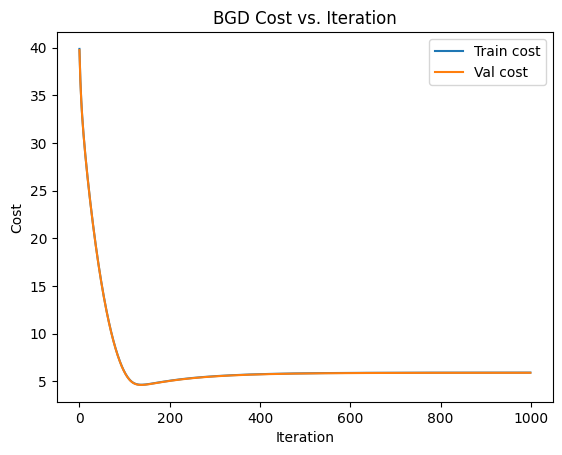

In [39]:
data = io.loadmat('data.mat')
X_train, y_train, X_val, y_val, X_test = preProcess(data)
lambda_reg = 0.1   # L2 reg strength
eta = 0.01         # learning rate
num_iters = 1000   #
w, cost_history, val_cost_history = train_bgd(
        X_train, y_train,
        X_val,   y_val,
        reg_lambda=lambda_reg,
        eta=eta,
        num_iters=num_iters
)

    # 5) Accuracy
acc_train = accuracy(X_train, y_train, w)
acc_val   = accuracy(X_val,   y_val,   w)
print(f"Final Training Accuracy:   {acc_train:.4f}")
print(f"Final Validation Accuracy: {acc_val:.4f}")

    # 6) Plot cost
plt.figure()
plt.plot(cost_history, label='Train cost')
plt.plot(val_cost_history, label='Val cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.title('BGD Cost vs. Iteration')
plt.show()




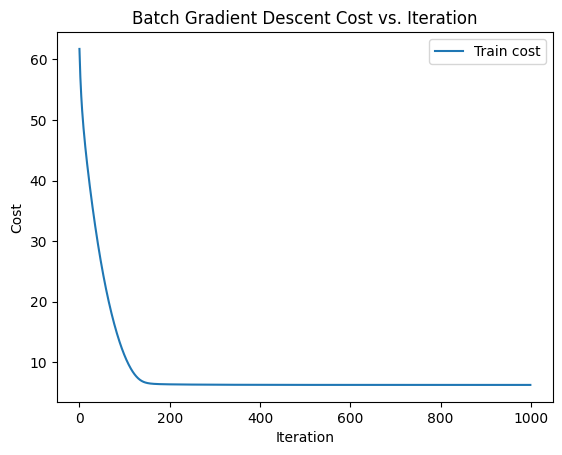

In [43]:
def train_bgd_all(X, y, reg_lambda, eta, num_iters=1000):
    """
    Train logistic regression with batch gradient descent on the full dataset.
    """
    w = np.zeros(X.shape[1], dtype=float)  # initialize weights
    cost_history = []
    
    for i in range(num_iters):
        w = batch_update(X, y, w, reg_lambda, eta)
        cost_train = j(X, y, w, reg_lambda)  # Compute cost for monitoring
        cost_history.append(cost_train)

    return w, cost_history

def predict_all(X, w):
    return (sigmoid(X @ w) >= 0.5).astype(int)


data = io.loadmat('data.mat')
X_all = data['X']        # shape (5000, 12)
y_all = data['y'].flatten()  # shape (5000,)
X_test = data['X_test']  # shape (1000, 12)

mean = X_all.mean(axis=0)
std = X_all.std(axis=0) + 1e-10  # Avoid division by zero
X_all_norm = (X_all - mean) / std
X_test_norm = (X_test - mean) / std

X_all_norm = np.hstack([np.ones((X_all_norm.shape[0], 1)), X_all_norm])
X_test_norm = np.hstack([np.ones((X_test_norm.shape[0], 1)), X_test_norm])

# Set hyperparameters
lambda_reg = 0.1   # L2 regularization strength
eta = 0.01         # Learning rate
num_iters = 1000   # Number of iterations

# Train the final model on all the training data
w_all, cost_history = train_bgd_all(X_all_norm, y_all, lambda_reg, eta, num_iters)

# Predict on the test set
y_test_pred = predict_all(X_test_norm, w_all)

results_to_csv(y_test_pred, "wine-submission.csv")
plt.figure()
plt.plot(cost_history, label="Train cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.title("Batch Gradient Descent Cost vs. Iteration")
plt.show()